In [ ]:
import os
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
import sys

from src.data.preprocessing import crop_dataset, \
    crop_image_into_patches, \
    get_random_crops, \
    remove_blank_patches, \
    get_n_random_crops_per_image, remove_blank_patches

from src.utils.visualization import show_crop_sets

warnings.filterwarnings("ignore")

c:\Users\DELL\Documents\ProjetEcole\roadgen-cv\mon_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\DELL\Documents\ProjetEcole\roadgen-cv\mon_env\lib\site-packages\torch\amp\autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [4]:
PATH_TO_DATA = "../data/raw/"
PATH_TO_EXAMPLE_DATA = "../data/examples/original/"

Let's check out the raw data we're working with:

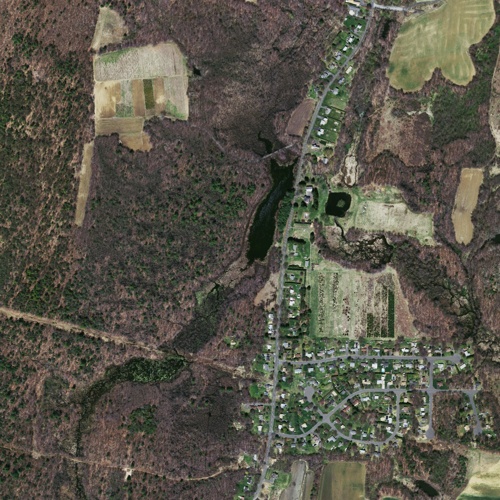

In [8]:
images_dir = Path(PATH_TO_EXAMPLE_DATA) / 'images'
img = Image.open(list(images_dir.iterdir())[0])
img.thumbnail((500, 500))
img

### Get random crops

In [9]:
train_crops, label_crops = get_random_crops(
    PATH_TO_DATA,
    patch_size=256,
    num_crops=16
)

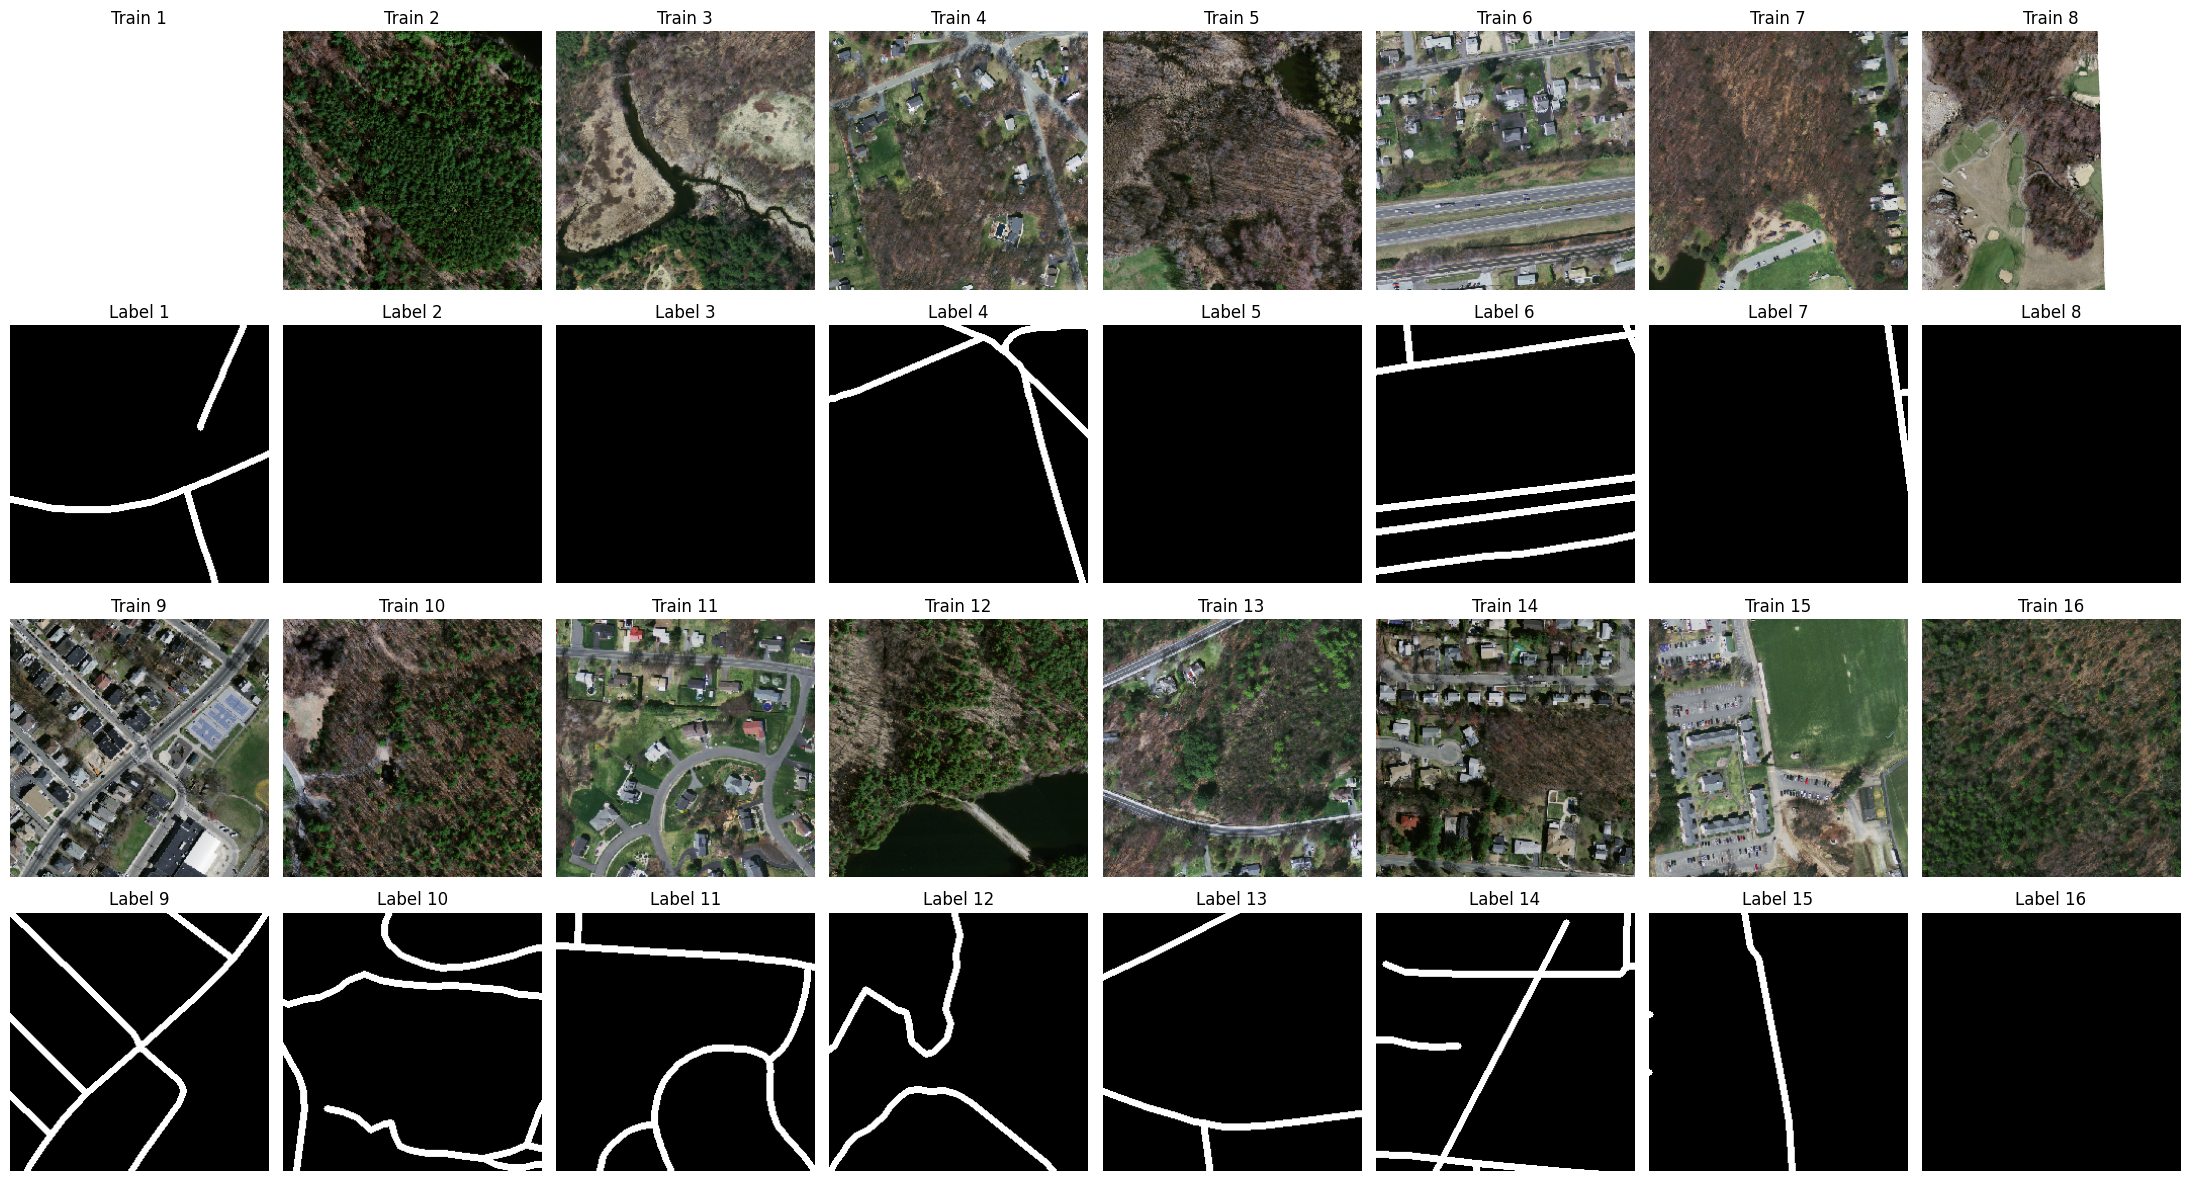

In [10]:
show_crop_sets(train_crops, label_crops)

We spot two issues:
- There are some white spots on training images
- Some crops have zero roads (i.e. the label a full black image)

We solve this by writing a method to determine the percentage of pure white pixels. For our training images, we discard images with **more** than 5% of pure white pixels. For our label images, we discard images with **less** than 5% of pure white pixels. This should handle the crop issues. 

In [11]:
from src.utils.image import white_pixel_percentage

In [12]:
print("Percentage in label image:", white_pixel_percentage(label_crops[0]))
print("Percentage in training image:", white_pixel_percentage(train_crops[0]))

Percentage in label image: 4.81109619140625
Percentage in training image: 100.0


### Trying out various sampling methods:

We have huge 1500x1500 images and we want to extract 256x256 crops from these images. But how?

Two solutions envisioned:
- Extract $n$ images at random locations for each image in the dataset.
- Extract in a grid, with or without overlap

We try out these two methods below:

#### Random sampling

Extracted 100 random crops from 10078660_15.jpg
Extracted 100 random crops from 10078675_15.jpg
Extracted 100 random crops from 10078690_15.jpg


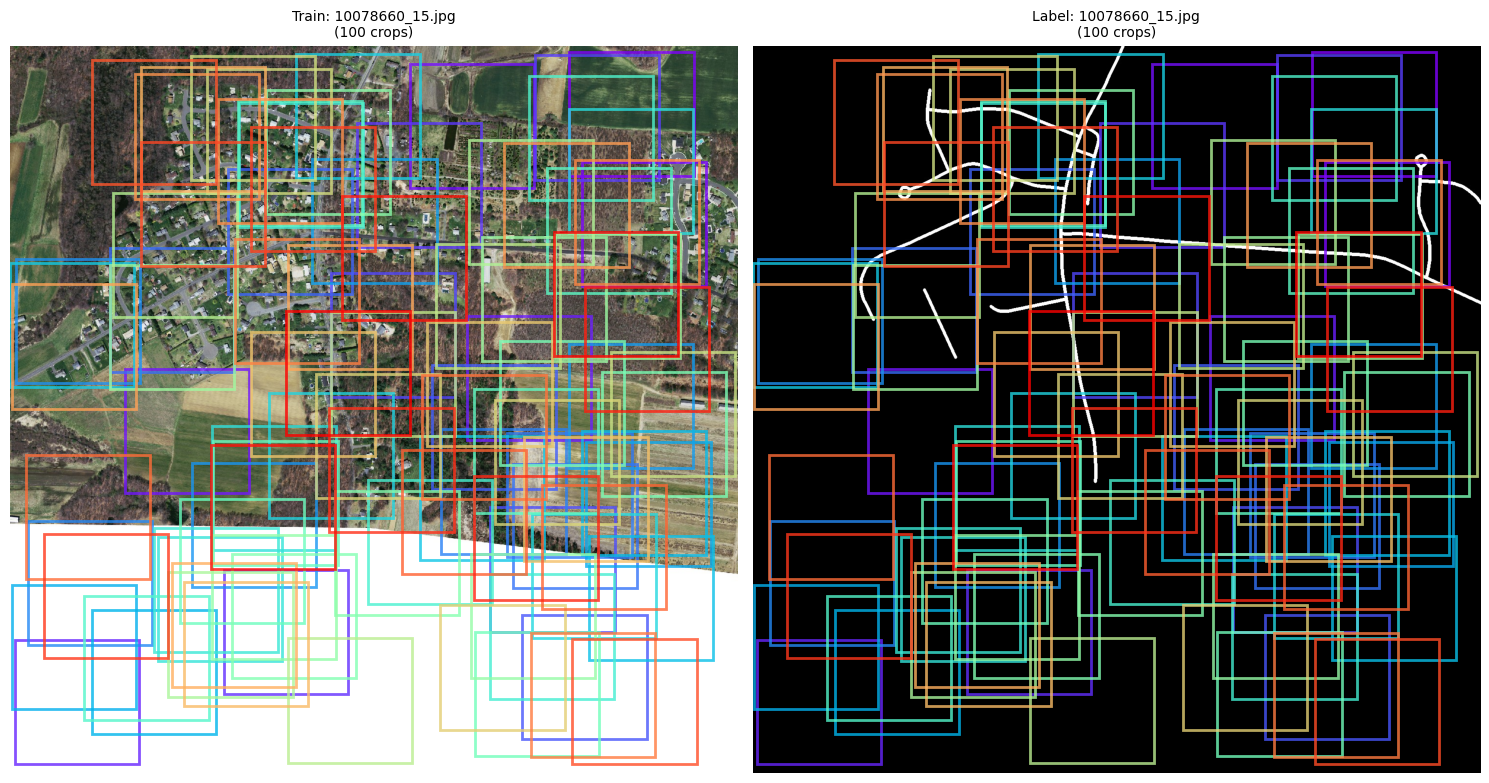

In [13]:
from src.utils.visualization import visualize_crop_locations, visualize_coverage_map

# Get 50 random crops per image
result = get_n_random_crops_per_image(PATH_TO_EXAMPLE_DATA, n_crops_per_image=100, num_images=3, train_subdir="images", labels_subdir="labels")

_ = visualize_crop_locations(
    PATH_TO_EXAMPLE_DATA,
    train_subdir="images",
    labels_subdir="labels",
    metadata=result['metadata'],
    max_images=1
)

Overall Statistics:
  Total images: 3
  Total crops: 300
  Average coverage: 84.16%
  Average overlap area: 69.35%
  Average overlap ratio: 0.82
  Average overlap depth: 3.46


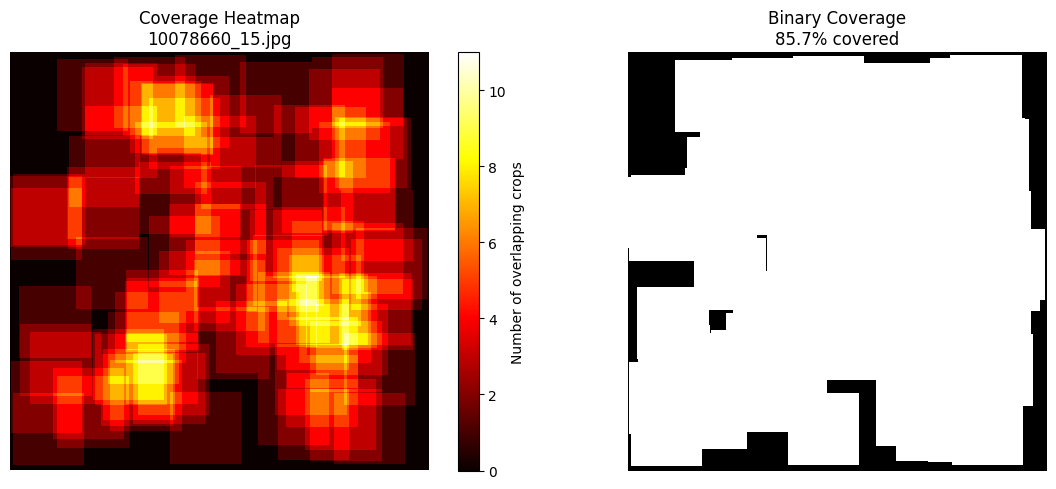


Statistics for 10078660_15.jpg:
  Number of crops: 100
  Total area covered: 85.70%
  Area with overlaps: 68.47%
  Overlap ratio: 0.80 (79.9% of covered area is overlapped)
  Average overlap depth: 3.40 crops per covered pixel
  Max overlap depth: 11 crops on same pixel


In [14]:
from src.utils.image import calculate_crop_coverage_stats

# Calculate coverage statistics from the metadata
coverage_stats = calculate_crop_coverage_stats(
    result['metadata'], 
    patch_size=256, 
    image_size=(1500, 1500)
)

# Print overall statistics
print("Overall Statistics:")
print(f"  Total images: {coverage_stats['num_images']}")
print(f"  Total crops: {coverage_stats['total_crops']}")
print(f"  Average coverage: {coverage_stats['avg_coverage_pct']:.2f}%")
print(f"  Average overlap area: {coverage_stats['avg_overlap_pct']:.2f}%")
print(f"  Average overlap ratio: {coverage_stats['avg_overlap_ratio']:.2f}")
print(f"  Average overlap depth: {coverage_stats['avg_overlap_depth']:.2f}")

# Visualize coverage of first image
_ = visualize_coverage_map(coverage_stats, image_idx=0)

#### Grid sampling (with overlap)

In [15]:
result = crop_dataset(PATH_TO_DATA, num_images=3, overlap=True)

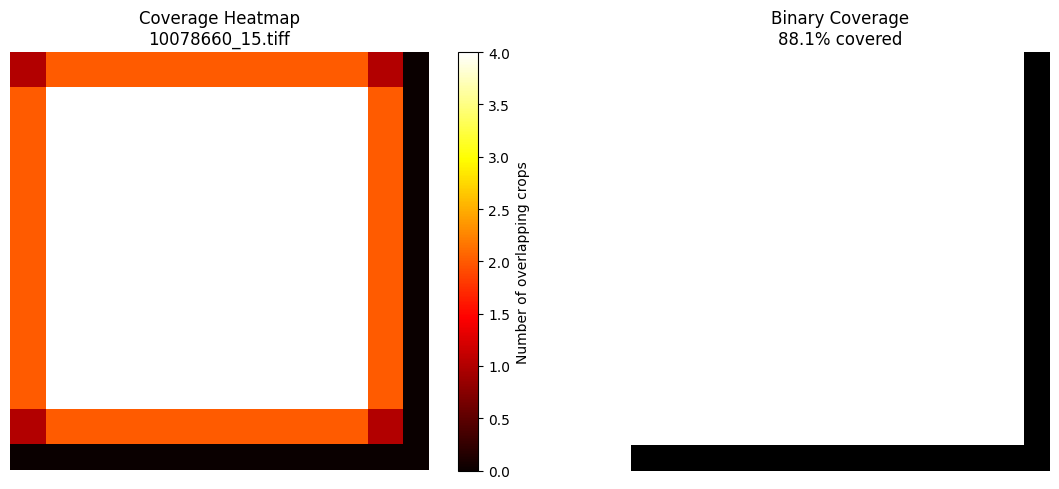


Statistics for 10078660_15.tiff:
  Number of crops: 100
  Total area covered: 88.11%
  Area with overlaps: 85.20%
  Overlap ratio: 0.97 (96.7% of covered area is overlapped)
  Average overlap depth: 3.31 crops per covered pixel
  Max overlap depth: 4 crops on same pixel


In [16]:
coverage_stats = calculate_crop_coverage_stats(
    result['metadata'], 
    patch_size=256, 
    image_size=(1500, 1500)
)

_ = visualize_coverage_map(coverage_stats)

We are able to extract 100 crops from each image in the dataset using this method. Given that we have 1108 images in the training set, this means we will get 110.800 crops, which after removal of the roadless and white tiles should give us about 50.000 training examples. Since this seems to be plenty enough for training such a GAN, we chose to use this without further data augmentation for now.

### Extract the patches

In [ ]:
os.makedirs("../data/processed/patches_256/", exist_ok=True)

metadata = crop_dataset(
    PATH_TO_DATA,
    train_subdir="train",
    labels_subdir="train_labels",
    patch_size=256,
    overlap=True,
    output_dir="../data/processed/patches_256/"
)

#### Remove useless patches

As mentioned earlier, a lot of these crops are of no use, because there isnt any road in it or because the training image contains white borders. We discard them.

In [11]:
remove_blank_patches(
    "../data/processed/patches_256/",
    "../data/processed/filtered_patches_256/",
)

Kept: 56.48% of patches.


We end up with 62.582 in the training set only! This should be more than enough for training our model.